Registers all MRI modalities to axial plane and saves patient cases as 160x320x320x3 (z,x,y,c) `BraTSID.npy` arrays (R:t1w, G:FLAIR, B:T2). 

Additionally, registers [Task-1](https://www.synapse.org/#!Synapse:syn25829067/wiki/610863) segmentation masks to case and saves them as `BraTSID_seg.npy` 160x320x320 (z,x,y) arrays. This requires accepting Task-1 terms and downloading & extracting [this](https://www.kaggle.com/dschettler8845/load-task-1-dataset-comparison-w-task-2-dataset/data) set that @dschettler8845 uploaded.

- **Date:** 2021-08-28
- **Author:** [Joni Juvonen](https://www.kaggle.com/qitvision)

In [1]:
import os
import sys 
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import SimpleITK as sitk

In [2]:
train_path = '../input/rsna-miccai-brain-tumor-radiogenomic-classification/train/'
train_dirs = os.listdir(train_path)

In [ ]:
sitk.sitkNearestNeighbor

In [25]:
class Registered_BraTS_Case():
    
    def __init__(self, dicom_dir, resize_to, task1_dir=None):
        self.dicom_dir = dicom_dir
        self.resize_to = resize_to
        self.task1_dir = task1_dir
    
    @staticmethod
    def resample(image, ref_image):

        resampler = sitk.ResampleImageFilter()
        resampler.SetReferenceImage(ref_image)
        #resampler.SetInterpolator(sitk.sitkLinear)
        resampler.SetInterpolator(sitk.sitkNearestNeighbor)

        resampler.SetTransform(sitk.AffineTransform(image.GetDimension()))
        resampler.SetOutputSpacing(ref_image.GetSpacing())
        resampler.SetSize(ref_image.GetSize())
        resampler.SetOutputDirection(ref_image.GetDirection())
        resampler.SetOutputOrigin(ref_image.GetOrigin())
        resampler.SetDefaultPixelValue(image.GetPixelIDValue())
        resamped_image = resampler.Execute(image)
        
        return resamped_image
    
    @staticmethod
    def normalize(data):
        return (data - np.min(data)) / (np.max(data) - np.min(data))

    @staticmethod
    def get_crop_bb(image):
        inside_value = 0
        outside_value = 255
        label_shape_filter = sitk.LabelShapeStatisticsImageFilter()
        label_shape_filter.Execute( sitk.OtsuThreshold(image, inside_value, outside_value) )
        bounding_box = label_shape_filter.GetBoundingBox(outside_value)
        return bounding_box
    
    @staticmethod
    def crop_with_bb(image, bounding_box):
        # The bounding box's first "dim" entries are the starting index and last "dim" entries the size
        return sitk.RegionOfInterest(image, bounding_box[int(len(bounding_box)/2):], bounding_box[0:int(len(bounding_box)/2)])
    
    @staticmethod
    def threshold_based_crop(image):
        """
        This function is copied from here: https://github.com/InsightSoftwareConsortium/SimpleITK-Notebooks/blob/master/Python/70_Data_Augmentation.ipynb
        
        Use Otsu's threshold estimator to separate background and foreground. In medical imaging the background is
        usually air. Then crop the image using the foreground's axis aligned bounding box.
        Args:
            image (SimpleITK image): An image where the anatomy and background intensities form a bi-modal distribution
                                     (the assumption underlying Otsu's method.)
        Return:
            Cropped image based on foreground's axis aligned bounding box.                                 
        """
        # Set pixels that are in [min_intensity,otsu_threshold] to inside_value, values above otsu_threshold are
        # set to outside_value. The anatomy has higher intensity values than the background, so it is outside.
        inside_value = 0
        outside_value = 255
        label_shape_filter = sitk.LabelShapeStatisticsImageFilter()
        label_shape_filter.Execute( sitk.OtsuThreshold(image, inside_value, outside_value) )
        bounding_box = label_shape_filter.GetBoundingBox(outside_value)
        # The bounding box's first "dim" entries are the starting index and last "dim" entries the size
        return sitk.RegionOfInterest(image, bounding_box[int(len(bounding_box)/2):], bounding_box[0:int(len(bounding_box)/2)])

    @staticmethod
    def swap_image_axes(image, order):
        return sitk.PermuteAxes(image, order)

    @staticmethod
    def axis_swap_order(image):
        direction = np.array([int(round(d)) for d in image.GetDirection()])
        if np.all(direction == np.array([1, 0, 0, 0, 1, 0, 0, 0, 1])):
            return [0,1,2]
        elif np.all(direction == np.array([0, 0, -1, 1, 0, 0, 0, -1, 0])):
            return [2,0,1]
        elif np.all(direction == np.array([1, 0, 0, 0, 0, 1, 0, -1, 0])):
            return [0,2,1]
        else:
            print(list(direction))
            return [0,1,2]

    @staticmethod
    def maybe_flip_axes(image):
        direction = np.array([int(round(d)) for i,d in enumerate(image.GetDirection()) if i%4==0])
        flips = [bool(d == -1) for d in direction]
        return sitk.Flip(image, list(flips))
    
    @staticmethod
    def resize_image(original_CT, resize_to=[256,256,100]):

        dimension = original_CT.GetDimension()
        reference_physical_size = np.zeros(original_CT.GetDimension())
        reference_physical_size[:] = [(sz-1)*spc if sz*spc>mx  else mx for sz,spc,mx in zip(original_CT.GetSize(), original_CT.GetSpacing(), reference_physical_size)]

        reference_origin = original_CT.GetOrigin()
        reference_direction = original_CT.GetDirection()

        reference_size = resize_to
        reference_spacing = [ phys_sz/(sz-1) for sz,phys_sz in zip(reference_size, reference_physical_size) ]

        reference_image = sitk.Image(reference_size, original_CT.GetPixelIDValue())
        reference_image.SetOrigin(reference_origin)
        reference_image.SetSpacing(reference_spacing)
        reference_image.SetDirection(reference_direction)

        reference_center = np.array(reference_image.TransformContinuousIndexToPhysicalPoint(np.array(reference_image.GetSize())/2.0))

        transform = sitk.AffineTransform(dimension)
        transform.SetMatrix(original_CT.GetDirection())

        transform.SetTranslation(np.array(original_CT.GetOrigin()) - reference_origin)

        centering_transform = sitk.TranslationTransform(dimension)
        img_center = np.array(original_CT.TransformContinuousIndexToPhysicalPoint(np.array(original_CT.GetSize())/2.0))
        centering_transform.SetOffset(np.array(transform.GetInverse().TransformPoint(img_center) - reference_center))
        centered_transform = sitk.Transform(transform)
        centered_transform = sitk.Transform(centering_transform)

        return sitk.Resample(original_CT, reference_image, centered_transform, sitk.sitkLinear, 0.0)

    def get_registered_case(self, brat_id_str):
        """ Return stack of min-max normalized R:t1wCE, G:flair, B:T2 array """
        stacked = np.zeros(tuple([self.resize_to[2],*self.resize_to[:2],3]))
        try:
            # init sitk reader
            reader = sitk.ImageSeriesReader()
            reader.LoadPrivateTagsOn()
            reader.SetOutputPixelType(sitk.sitkFloat32)
            
            # Use t1w as the reference and skip flair because it's sometimes completely dark
            filenamesDICOM = reader.GetGDCMSeriesFileNames(f'{self.dicom_dir}/{brat_id_str}/T1wCE')
            reader.SetFileNames(filenamesDICOM)
            t1w = reader.Execute()

            filenamesDICOM = reader.GetGDCMSeriesFileNames(f'{self.dicom_dir}/{brat_id_str}/FLAIR')
            reader.SetFileNames(filenamesDICOM)
            flair = reader.Execute()

            filenamesDICOM = reader.GetGDCMSeriesFileNames(f'{self.dicom_dir}/{brat_id_str}/T2w')
            reader.SetFileNames(filenamesDICOM)
            t2 = reader.Execute()
            
            # Align reference image and crop with otsu to minimum enclosing box
            t1w = self.swap_image_axes(t1w, self.axis_swap_order(t1w))
            t1w = self.maybe_flip_axes(t1w)
            bounding_box = self.get_crop_bb(t1w)
            
            # resample other modalities to align with reference
            flair_resampled = self.resample(flair, t1w)
            t2_resampled = self.resample(t2, t1w)
            
            # crop all modalities to same box
            t1w_cropped = self.crop_with_bb(t1w, bounding_box)
            t1w_cropped = self.resize_image(t1w_cropped, self.resize_to)

            flair_cropped = self.crop_with_bb(flair_resampled, bounding_box)
            flair_cropped = self.resize_image(flair_cropped, self.resize_to)

            t2_cropped = self.crop_with_bb(t2_resampled, bounding_box)
            t2_cropped = self.resize_image(t2_cropped, self.resize_to)
            
            # Return stack of min-max normalized R:t1w, G:T1ce, B:T2 array
            stacked = np.stack([
                self.normalize(sitk.GetArrayFromImage(t1w_cropped)),
                self.normalize(sitk.GetArrayFromImage(flair_cropped)),
                self.normalize(sitk.GetArrayFromImage(t2_cropped))
            ], axis=3)
        except:
            print(f'Error: {brat_id_str}')
        return stacked
    
    def get_aligned_seg_map(self, brat_id_str):
        """ Normalizes task 1 segmentation map with similar logic and returns an aligned seg map """
        if self.task1_dir is None:
            return None
        
        try:
            segmentation_nii_fn = [os.path.join(f'{self.task1_dir}/BraTS2021_{brat_id_str}/', fn) for fn in os.listdir(f'{self.task1_dir}/BraTS2021_{brat_id_str}/') if 'seg' in fn]
            t1_nii_fn = [os.path.join(f'{self.task1_dir}/BraTS2021_{brat_id_str}/', fn) for fn in os.listdir(f'{self.task1_dir}/BraTS2021_{brat_id_str}/') if 't1ce.' in fn]

            if len(segmentation_nii_fn) == 0 or len(t1_nii_fn) ==0:
                return None

            t1 = sitk.ReadImage(t1_nii_fn[0])
            seg = sitk.ReadImage(segmentation_nii_fn[0])

            t1 = self.swap_image_axes(t1, self.axis_swap_order(t1))
            t1 = self.maybe_flip_axes(t1)
            bounding_box = self.get_crop_bb(t1)

            seg_resampled = self.resample(seg, t1)
            seg_cropped = self.crop_with_bb(seg_resampled, bounding_box)
            seg_cropped = self.resize_image(seg_cropped, self.resize_to)
        except:
            print(f'Seg error: {brat_id_str}')
            return None

        return sitk.GetArrayFromImage(seg_cropped)

In [26]:
train_dir = train_dirs[200]
task1_dir = '../input/brats-2021-task1/BraTS2021_Training_Data'
resize_to=[320,320,160]

registered = Registered_BraTS_Case(dicom_dir=train_path, resize_to=resize_to, task1_dir=task1_dir)
reg_stack = registered.get_registered_case(brat_id_str=train_dir)
seg = registered.get_aligned_seg_map(brat_id_str=train_dir)

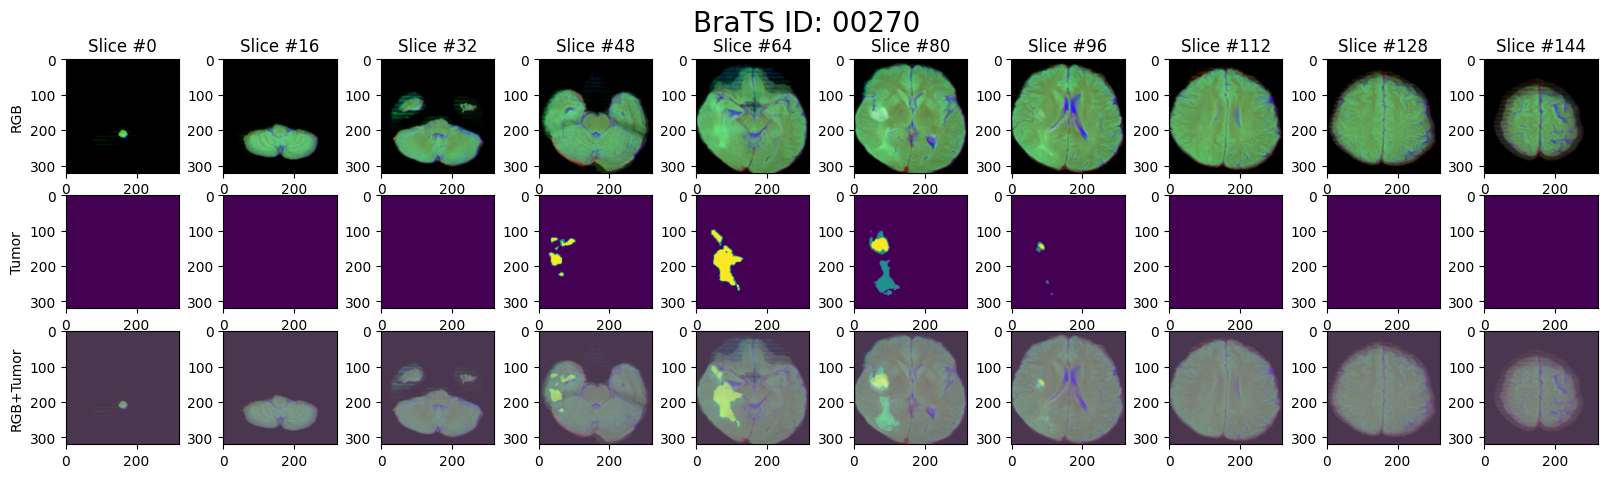

In [27]:
f, axs = plt.subplots(3,10, figsize=(20,5))

height_levels = resize_to[2]
for ind, j in enumerate(range(0, height_levels - 1, (height_levels//10))):
    if ind > 9:break
    axs[0,ind].imshow(reg_stack[j,:,:,:])
    
    axs[1, ind].imshow(seg[j,:,:])
    
    axs[2, ind].imshow(reg_stack[j,:,:,:], alpha=0.7)
    axs[2, ind].imshow(seg[j,:,:], alpha=0.3)
    axs[0,ind].set_title(f'Slice #{ind*(height_levels//10)}')

axs[0,0].set_ylabel('RGB')
axs[1,0].set_ylabel('Tumor')
axs[2,0].set_ylabel('RGB+Tumor')

plt.suptitle(f'BraTS ID: {train_dir}', fontsize=20)
plt.savefig('../media/registered_sample.png', transparent=False)
plt.show()

## Save files

In [28]:
from glob import glob
from joblib import Parallel,delayed
import subprocess
from tqdm.auto import tqdm

In [29]:
train_path = '../input/rsna-miccai-brain-tumor-radiogenomic-classification/train/'
train_dirs = os.listdir(train_path)

test_path = '../input/rsna-miccai-brain-tumor-radiogenomic-classification/test/'
test_dirs = os.listdir(test_path)

In [30]:
reg_dir = os.path.join('../input', 'registered_cases_v3_320x320x160')

def maybe_create_dir(_dir):
    if not os.path.exists(_dir): os.mkdir(_dir)

maybe_create_dir(reg_dir)
reg_test_dir = os.path.join(reg_dir, 'test')
reg_train_dir = os.path.join(reg_dir, 'train')

maybe_create_dir(reg_test_dir)
maybe_create_dir(reg_train_dir)

In [31]:
def save_case(brat_id_str, rgb_cohort_dir, resize_to, task1_dir, save_dir):
    registered = Registered_BraTS_Case(dicom_dir=rgb_cohort_dir, resize_to=resize_to, task1_dir=task1_dir)
    reg_stack = registered.get_registered_case(brat_id_str=brat_id_str)
    seg = registered.get_aligned_seg_map(brat_id_str=brat_id_str)
    
    np.save(os.path.join(save_dir, brat_id_str + '.npy'),reg_stack)
    if seg is not None:
        np.save(os.path.join(save_dir, brat_id_str + '_seg.npy'),seg)

def save_train_case(brat_id_str):
    save_case(brat_id_str, train_path, resize_to, task1_dir, save_dir=reg_train_dir)

def save_test_case(brat_id_str):
    save_case(brat_id_str, test_path, resize_to, task1_dir, save_dir=reg_test_dir)

In [32]:
n_jobs = 8

mp_train = Parallel(
    n_jobs = n_jobs,
    prefer = 'threads')(delayed(save_train_case)(brat_id_str) for brat_id_str in tqdm(train_dirs, total=len(train_dirs)))

  0%|          | 0/585 [00:00<?, ?it/s]

<ipython-input-25-c25406550d93>:28: RuntimeWarning: invalid value encountered in true_divide
  return (data - np.min(data)) / (np.max(data) - np.min(data))


Seg error: 00169
Seg error: 00197
Seg error: 00245
Seg error: 00308
Seg error: 00408
Seg error: 00564
Seg error: 00794
Seg error: 00998


In [33]:
mp_test = Parallel(
    n_jobs = n_jobs,
    prefer = 'threads')(delayed(save_test_case)(brat_id_str) for brat_id_str in tqdm(test_dirs, total=len(test_dirs)))

  0%|          | 0/87 [00:00<?, ?it/s]

Seg error: 00592
Seg error: 00422
Seg error: 00181
Seg error: 00001
Seg error: 00027
Seg error: 00013
Seg error: 00037
Seg error: 00015
Seg error: 00114
Seg error: 00119
Seg error: 00047
Seg error: 00079
Seg error: 00125
Seg error: 00129
Seg error: 00080
Seg error: 00091
Seg error: 00145
Seg error: 00135
Seg error: 00082
Seg error: 00161
Seg error: 00182
Seg error: 00153
Seg error: 00163
Seg error: 00174
Seg error: 00190
Seg error: 00200
Seg error: 00208
Seg error: 00213
Seg error: 00229
Seg error: 00307
Seg error: 00252
Seg error: 00256
Seg error: 00264
Seg error: 00287
Seg error: 00323
Seg error: 00333
Seg error: 00337
Seg error: 00355
Seg error: 00381
Seg error: 00372
Seg error: 00335
Seg error: 00384
Seg error: 00393
Seg error: 00428
Seg error: 00450
Seg error: 00460
Seg error: 00434
Seg error: 00447
Seg error: 00438
Seg error: 00458
Seg error: 00462
Seg error: 00463
Seg error: 00467
Seg error: 00474
Seg error: 00492
Seg error: 00489
Seg error: 00503
Seg error: 00573
Seg error: 005